### Import dependencies

In [118]:
# !pip install tensorflow_hub

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


import tensorflow_hub as hub
import keras
from keras import Sequential, layers, models
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

### Setup data inputs

In [4]:
# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "skintype-data/train/"
test_dir = "skintype-data/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)
test_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 208 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


In [5]:
# Class labels

import pathlib 
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['normal_skin' 'oily_skin']


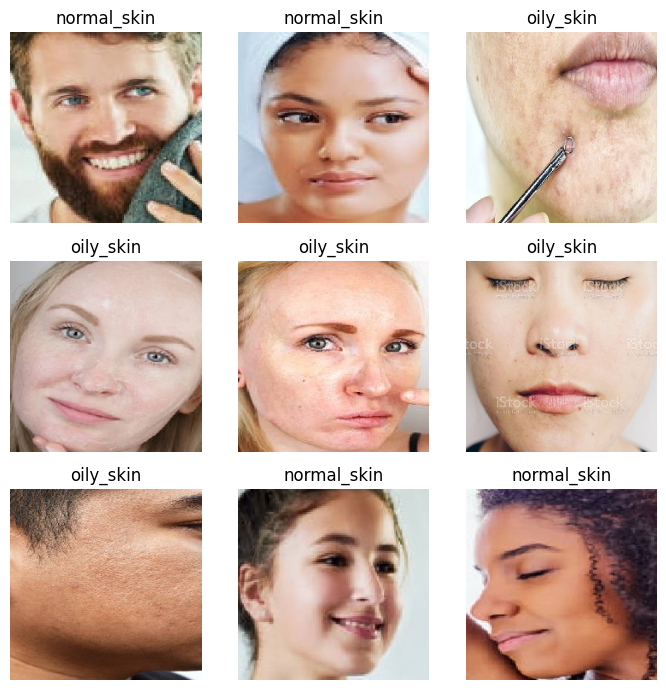

In [120]:
# Display images from train_data
plt.figure(figsize=(7, 7))
for images, labels in train_data:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        ax.imshow(images[i])
        ax.set_title(class_names[labels[i].argmax()])
        ax.axis("off")

    if i == 8:
        break

plt.tight_layout()
plt.show()

### Build Keras sequential model with a pretrained model(EfficientNet-B0 architecture) as the feature extractor

See more on transfer learning with <a href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub">Tensorflow Hub</a>.

In [93]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

def create_model(model_url, num_classes=2):
  """ Take a TensorFlow Hub URL and creates a Keras Sequential model with it.  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,   # freeze the already learned patterns
                                           name="EfficientnetB0_model",
                                           input_shape=IMAGE_SHAPE+(3,))  # define the input image shape
  # Create the image model
  model = Sequential([
    feature_extractor_layer,    # use the feature extraction layer as the base
    layers.Dense(num_classes, activation="sigmoid", name="output_layer")   # create our own output layer
  ])
  return model

In [94]:
# Create EfficientNet model (using Transfer learning from The EfficientNet-B0 architecture)
efficientnet_model = create_model(efficientnet_url,
                            num_classes=2)
# Compile
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [95]:
efficientnet_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientnetB0_model (Keras  (None, 1280)             4049564   
 Layer)                                                          
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 2,562
Non-trainable params: 4,049,564
_________________________________________________________________


In [96]:
# Fit the model
efficientnet_history = efficientnet_model.fit(train_data,
                                  validation_data=test_data, 
                                  epochs=10,
                                    )   # name of log files

Epoch 1/10
7/7 [==============================] - 30s 3s/step - loss: 0.7004 - accuracy: 0.5721 - val_loss: 0.5389 - val_accuracy: 0.7308
Epoch 2/10
7/7 [==============================] - 16s 2s/step - loss: 0.5065 - accuracy: 0.7596 - val_loss: 0.4304 - val_accuracy: 0.7885
Epoch 3/10
7/7 [==============================] - 19s 3s/step - loss: 0.3942 - accuracy: 0.8606 - val_loss: 0.3936 - val_accuracy: 0.8462
Epoch 4/10
7/7 [==============================] - 18s 3s/step - loss: 0.3395 - accuracy: 0.8798 - val_loss: 0.3688 - val_accuracy: 0.8462
Epoch 5/10
7/7 [==============================] - 20s 3s/step - loss: 0.3033 - accuracy: 0.8894 - val_loss: 0.3379 - val_accuracy: 0.8462
Epoch 6/10
7/7 [==============================] - 18s 3s/step - loss: 0.2760 - accuracy: 0.8990 - val_loss: 0.3195 - val_accuracy: 0.8462
Epoch 7/10
7/7 [==============================] - 20s 3s/step - loss: 0.2564 - accuracy: 0.9135 - val_loss: 0.3162 - val_accuracy: 0.8462
Epoch 8/10
7/7 [==================

In [99]:
efficientnet_model.save('../models/Skintype-Model')

INFO:tensorflow:Assets written to: ../models/Skintype-Model\assets


INFO:tensorflow:Assets written to: ../models/Skintype-Model\assets


In [2]:
model = models.load_model('../models/Skintype-Model')

# Check the architecture of the loaded model
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientnetB0_model (Keras  (None, 1280)             4049564   
 Layer)                                                          
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 2,562
Non-trainable params: 4,049,564
_________________________________________________________________


In [3]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """ Reads in an image from filename, turns it into a tensor and reshapes into (224,224,3). """
  
  # Read in the image and decode it into a tensor
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img)
    
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [8]:
def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]
  
  print('Prediction Probabilities : ', pred[0])

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Predicted skintype: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 106ms/step
Prediction Probabilities :  [0.12001417 0.8847004 ]


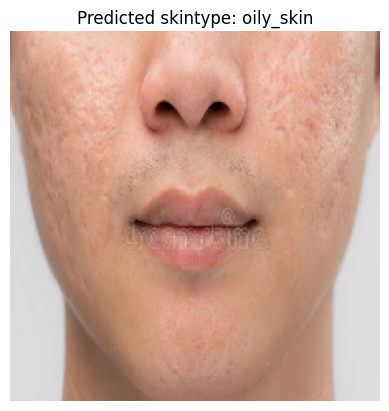

In [9]:
# Test model on oily skin
pred_and_plot(model=model, 
              filename="skintype-data/test/oily_skin/c129.jpeg", 
              class_names=class_names)

1/1 [==============================] - 0s 352ms/step
Prediction Probabilities :  [0.5546787  0.38871115]


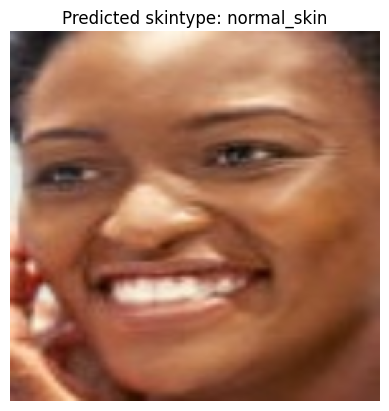

In [117]:
# Test model on normal skin
pred_and_plot(model=model, 
              filename="skintype-data/test/normal_skin/c116.jpeg", 
              class_names=class_names)